# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import json

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from plotting_functions import plot_roc_curves, plot_classification_report, plot_confusion_matrices
from utils import build_resampled_datasets, best_f1_score

# from google.colab import drive
# drive.mount('/content/drive')
import pickle

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

Pipeline

PCA -> Sampling methods -> training with gridsearch cv parameter searching -> classification on unknown dataset with best achieved (or specific upsampling like SMOTE) f1 score parameters -> final decission >=4

In [2]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [3]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')
df_cl = df_cl.drop(['PC1', 'PC2', 'kmeans_pca', 'kmeans', 'kmeans_audience', 'dbscan', 'agg'], axis=1)
df_un_orig = pd.read_excel('movies_test_anon.xlsx')

In [4]:
len(df_cl.columns)

62

# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

## 5.1 Δημιουργία συνόλων δεδομένων upsamling, downsampling SMOTE

In [5]:
df = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

train_datasets, test_dataset = build_resampled_datasets(df, test_ratio=0.2)

In [6]:
train_datasets.keys()

dict_keys(['default', 'upsampled', 'downsampled', 'SMOTE'])

## 5.2 Εκπαίδευση μοντέλων με grid search cross validation

In [7]:
results = {}

### 5.2.1 ADA Boost

In [8]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):    

    parameters = {
            'n_estimators': range(10, 201, 10),
    }

    model = AdaBoostClassifier(random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['ADA'][sampling] = {
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                # 'X_train' : X_train,
                # 'y_train' : y_train,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best parameters for default: {'n_estimators': 10}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for upsampled: {'n_estimators': 170}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for downsampled: {'n_estimators': 30}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for SMOTE: {'n_estimators': 180}


### 5.2.2 Gradient Boost

In [9]:
# Gradient boosting classifier
results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):  

    parameters = {
         "learning_rate": [x/100 for x in range(10,101,20)], 
         "max_depth": [3,5,7], 
         "n_estimators": range(10, 201, 20),
    }

    model = GradientBoostingClassifier(random_state=1) 

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['GRB'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for default: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for upsampled: {'learning_rate': 0.9, 'max_depth': 5, 'n_estimators': 70}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for downsampled: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 130}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters for SMOTE: {'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 130}


### 5.2.3 Decision Tree

In [10]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()): 

    parameters = {   
        'min_samples_split' : range(2, 51, 2),
        'min_samples_leaf' : range(1, 51, 2),
    }

    model = DecisionTreeClassifier(random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    results['DT'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for default: {'min_samples_leaf': 3, 'min_samples_split': 14}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for upsampled: {'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for downsampled: {'min_samples_leaf': 35, 'min_samples_split': 2}
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best parameters for SMOTE: {'min_samples_leaf': 1, 'min_samples_split': 4}


### 5.2.4 Random Forest

In [11]:
# Random forest
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):   

    parameters = {
        # 'min_samples_leaf': range(1, 51, 2),
        # 'min_samples_split': range(2, 51, 2),
        'n_estimators': range(10, 201, 20)
    }

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['RF'][sampling] = {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for default: {'n_estimators': 190}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for upsampled: {'n_estimators': 130}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for downsampled: {'n_estimators': 30}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for SMOTE: {'n_estimators': 90}


### 5.2.5 K-Nearest Neighbors

In [12]:
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):   

    parameters = {
        "n_neighbors": range(2,20,2),
        'leaf_size' : range(10, 201, 10)
    }

    model = KNeighborsClassifier(n_jobs=-1)

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    results['KNN'][sampling]= {
                # 'fold' : str(i),
                'report' : classification_report(y_test, y_pred, output_dict=True, zero_division=0.0),
                'preds' : y_pred,
                'true' : y_test,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

    

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for default: {'leaf_size': 10, 'n_neighbors': 4}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for upsampled: {'leaf_size': 10, 'n_neighbors': 2}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for downsampled: {'leaf_size': 10, 'n_neighbors': 10}
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for SMOTE: {'leaf_size': 10, 'n_neighbors': 2}


## 5.3 Μετρικές εκπαίδευσης

### 5.3.1 Αναφορά κατηγοριοποίησης στο σύνολο δοκιμής

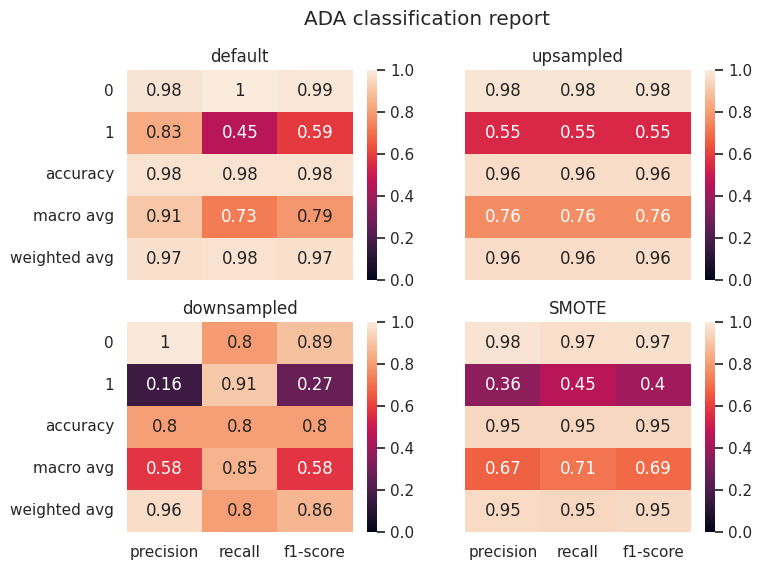

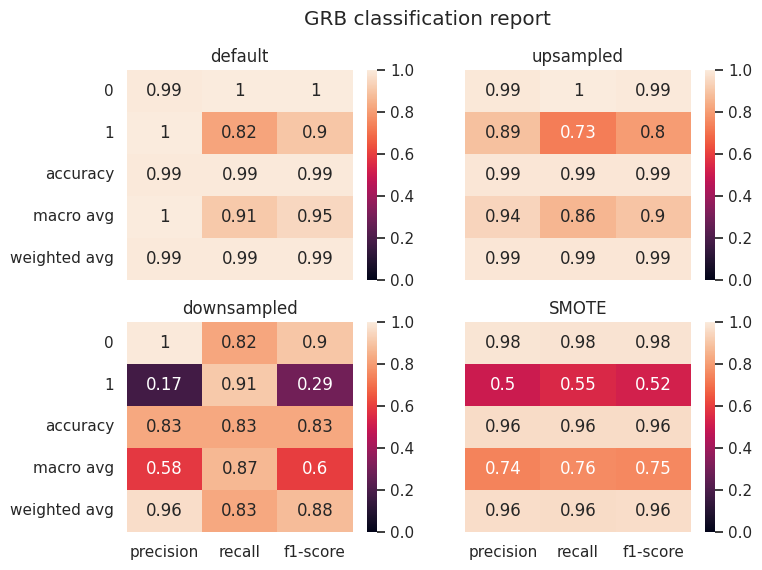

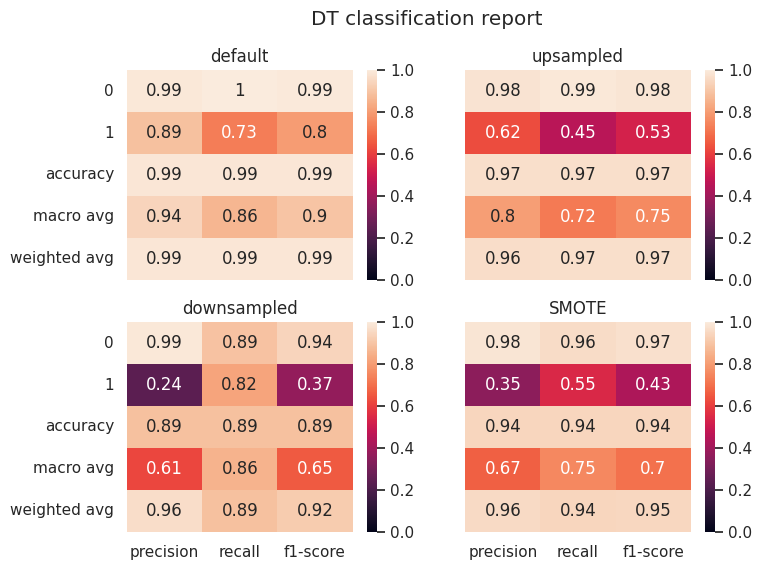

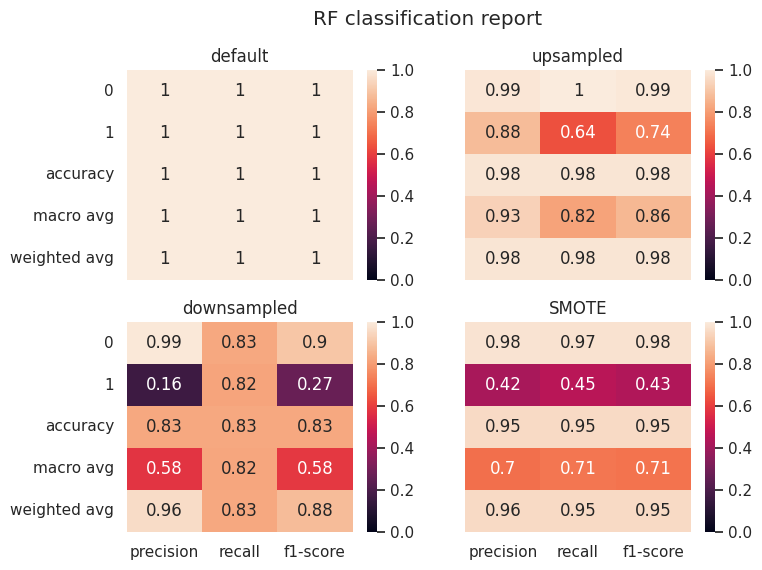

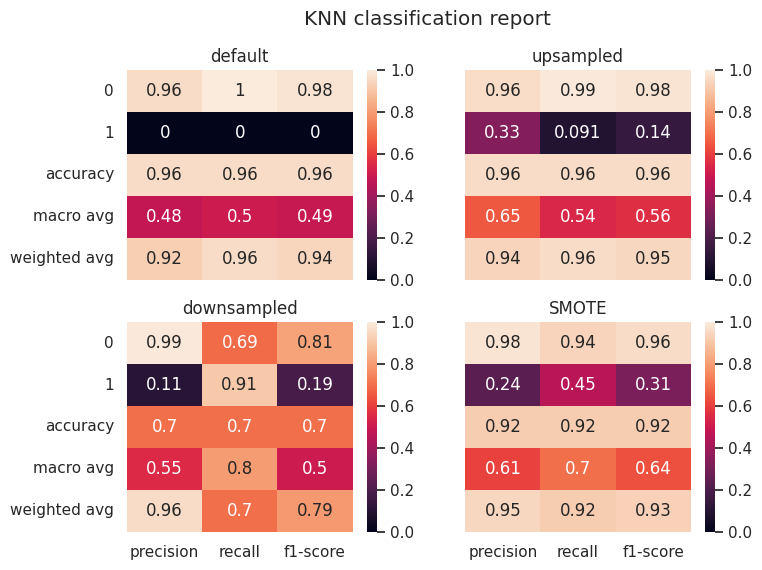

In [13]:
plot_classification_report(results, 'ADA')
plot_classification_report(results, 'GRB')
plot_classification_report(results, 'DT')
plot_classification_report(results, 'RF')
plot_classification_report(results, 'KNN')

### 5.3.2 Καμπύλες ROC

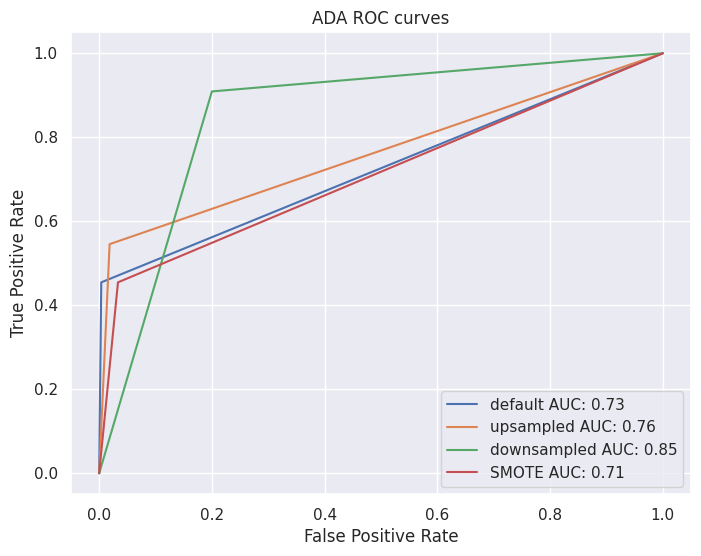

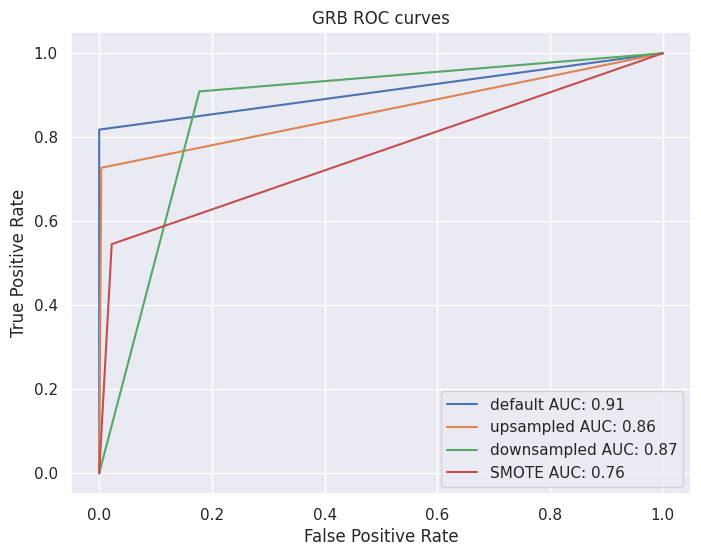

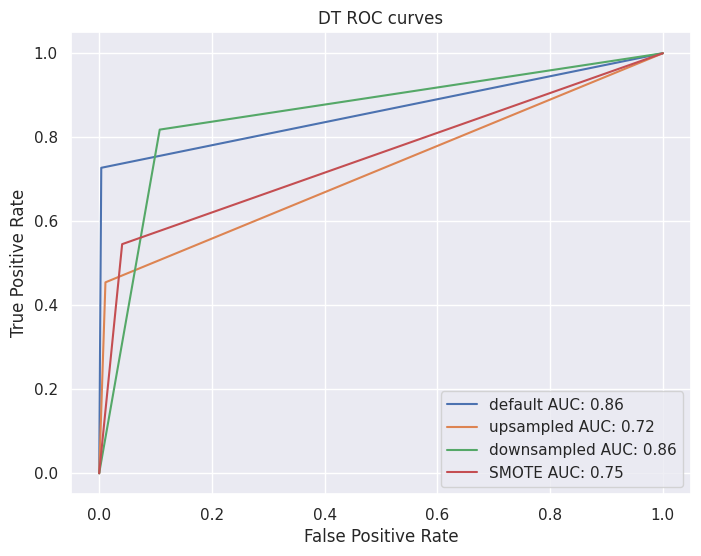

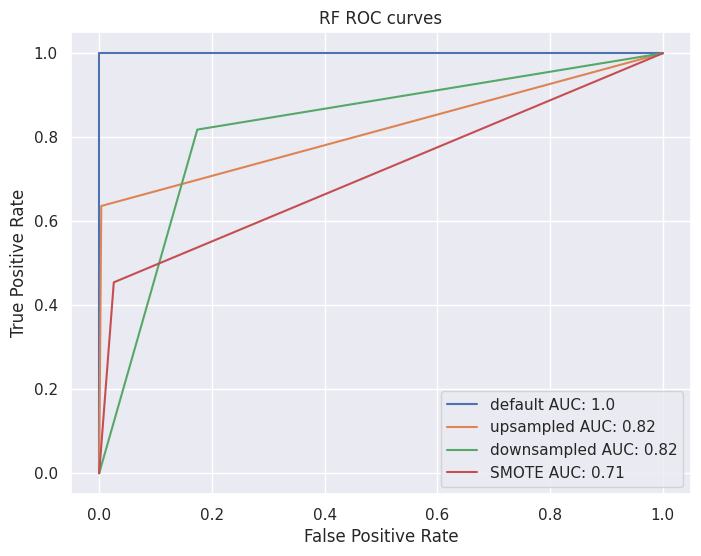

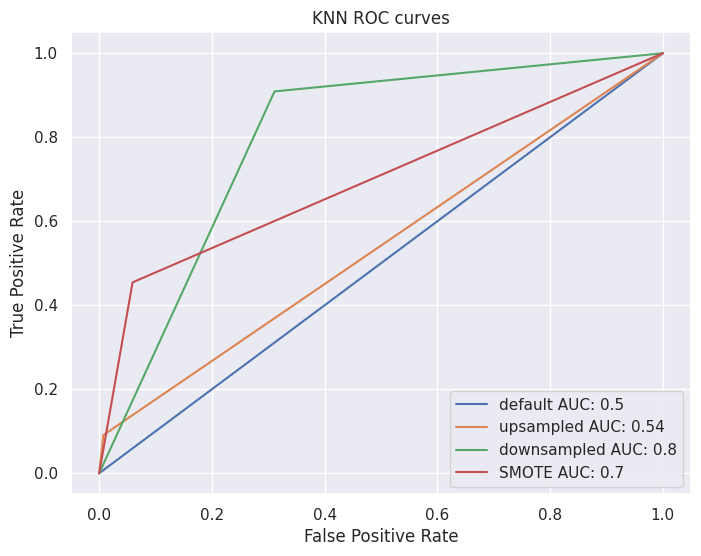

In [14]:
plot_roc_curves(results, 'ADA')
plot_roc_curves(results, 'GRB')
plot_roc_curves(results, 'DT')
plot_roc_curves(results, 'RF')
plot_roc_curves(results, 'KNN')

### 5.3.3 Πίνακες σύγχησης

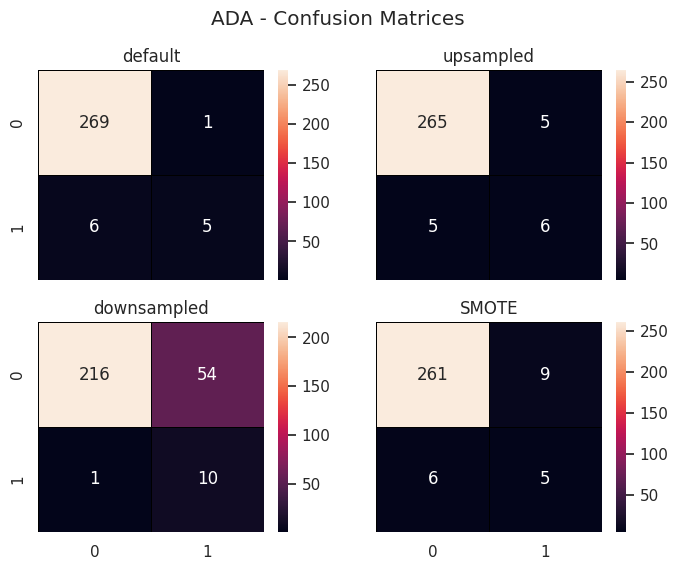

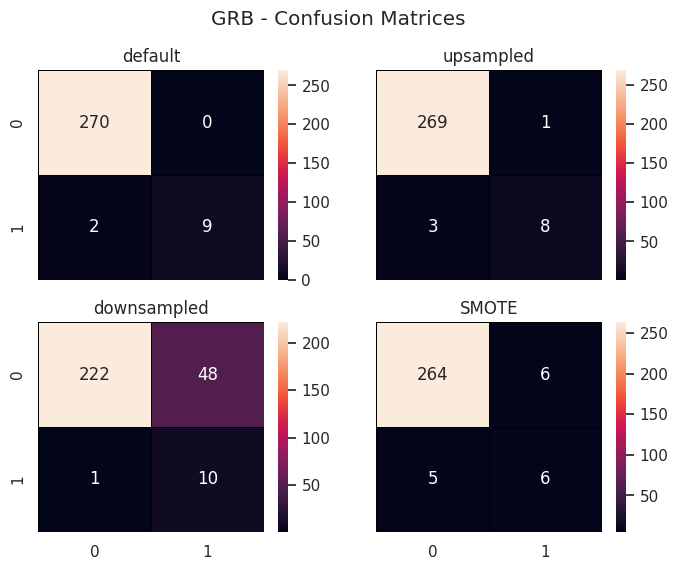

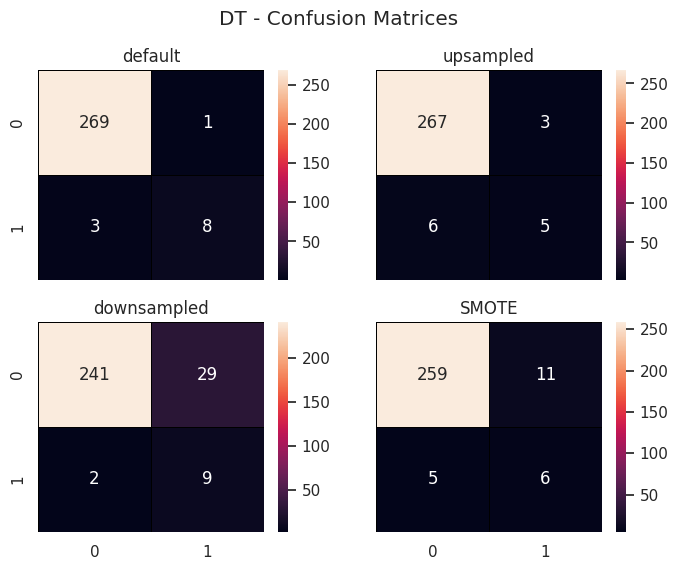

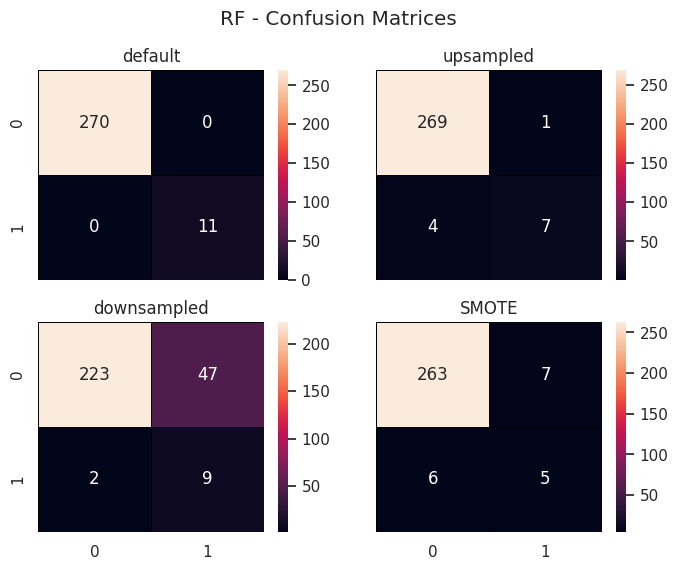

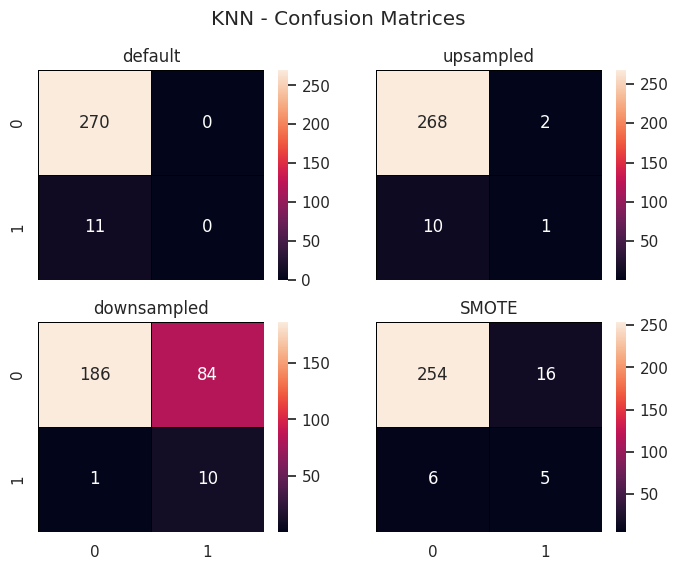

In [15]:
plot_confusion_matrices(results, 'ADA')
plot_confusion_matrices(results, 'GRB')
plot_confusion_matrices(results, 'DT')
plot_confusion_matrices(results, 'RF')
plot_confusion_matrices(results, 'KNN')

# 6. Προβλέψεις στο άγνωστο σύνολο δεδομένων

## 6.1 Φόρτωση του άγνωστου συνόλου δεδομένων

In [16]:
X = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)

## 6.2 Φόρτωση παραμέτρων και κατηγοριοποίηση μοντέλων

### 6.2.1 ADA Boost

In [17]:
# best, sampling = best_f1_score(results, 'ADA')

In [18]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'ADA')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'n_estimators': 10}

In [19]:
model = AdaBoostClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

56

### 6.2.2 Gradient Boost

In [20]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'GRB')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}

In [21]:
model = GradientBoostingClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

16

### 6.2.3 Decision Tree

In [22]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'DT')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'min_samples_leaf': 3, 'min_samples_split': 14}

In [23]:
model = DecisionTreeClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

11

### 6.2.4 Random Forest

In [24]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'RF')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'n_estimators': 190}

In [25]:
model = RandomForestClassifier(**best['params'])

model.fit(X_train, y_train)
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

4

### 6.2.5 K-Nearest Neighbors

In [26]:
# find best f1 parameters
best, sampling = best_f1_score(results, 'KNN')
# get coresponding sampled dataset from best f1 parameters report
X_train, y_train = train_datasets[sampling].drop(['oscar_winners'], axis=1), train_datasets[sampling]['oscar_winners']
best['params']

{'leaf_size': 10, 'n_neighbors': 2}

In [27]:
model = KNeighborsClassifier(**best['params'])
model.fit(X_train, y_train)

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

37

## 6.3 Αποτελέσματα προβλέψεων

### 6.3.1 Αριθμός προβλέψεων oscar ανα μοντέλο

In [28]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,56,16,11,4,37


### 6.3.2 Λεπτομέρειες προβλέψεων μοντέλων

In [29]:
df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ID','ADA', 'GRB', 'DT','RF', 'KNN']]

,ID,ADA,GRB,DT,RF,KNN
12,13,1,0,0,0,0
20,21,0,0,0,0,1
26,27,0,0,0,0,1
39,40,1,0,0,0,0
44,45,1,0,1,1,0
...,...,...,...,...,...,...
528,529,1,0,0,0,0
547,548,1,0,0,0,0
551,552,0,0,0,0,1
556,557,0,0,0,0,1


### 6.3.3 Επιλογή τελικής απόφασης

In [34]:
# Majority vote
DECISION_THRESHOLD = 2
predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)
print(f"Final oscars prediction number: {len(predictions[predictions['OSCAR'] == 1])}")

Final oscars prediction number: 17


/tmp/ipykernel_327607/311422637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


In [31]:
predictions[predictions['OSCAR'] == 1]

,ID,ADA,GRB,DT,RF,KNN,OSCAR
44,45,1,0,1,1,0,1
51,52,1,1,1,0,0,1
79,80,1,0,1,0,1,1
93,94,1,0,0,0,1,1
97,98,1,0,0,0,1,1
132,133,1,1,1,1,0,1
146,147,1,1,1,0,0,1
148,149,0,1,1,1,0,1
215,216,0,1,0,0,1,1
218,219,1,0,0,0,1,1


### 6.3.4 Σύγκριση λόγου oscar / μη oscar στο αρχικό σύνολο και στο άγνωστο

In [32]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 3.01% | Testing dataset oscar prediction ratio: 3.99%


### 6.3.5 Αποθήκευση αποτελεσμάτων σε αρχείο

In [35]:
# Save file
# predictions = predictions.drop(['DT','ADA', 'GRB', 'RF', 'KNN'], axis=1)
# predictions.to_csv('./predictions_new.csv', index=False)